# Neural & Behavioral Modeling - Week 3 (Exercises)
by Cheng-Kuang Wu (r10922186@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import *
from typing import List, Callable

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9noepm30 because the default path (/home/ckwu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## 1 Replicate exisiting findings/models (10 points)
Based on your personal interest, please choose and replicate ONE of the following studies:

1. <a href="http://ccl.northwestern.edu/netlogo/models/FlockingVeeFormations">Flocking Vee Formations</a> in NetLogo's [Sample Models::Biology] 

2. <a href="http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation">Wolf-Sheep Predation</a> in NetLogo's [Sample Models::Biology] 

3. <a href="https://kknews.cc/zh-tw/news/p56pbrp.html">MIT Matching Game</a>

4. Gray, K., Rand, D. G., Ert, E., Lewis, K., Hershman, S., & Norton, M. I. (2014). <a href="http://www.mpmlab.org/groups/">The emergence of “us and them” in 80 lines of code: Modeling group genesis in homogeneous populations</a>. Psychological Science, 25(4), 982-990.

5. Luhmann, C. C., & Rajaram, S. (2015). <a href="http://journals.sagepub.com/doi/abs/10.1177/0956797615605798">Memory transmission in small groups and large networks: An agent-based model</a>. Psychological Science, 26(12), 1909-1917.

6. Henriques, G. J., Simon, B., Ispolatov, Y., & Doebeli, M. (2019). <a href="https://www.pnas.org/content/116/28/14089">Acculturation drives the evolution of intergroup conflict</a>. Proceedings of the National Academy of Sciences, 116(28), 14089-14097.

### 【2022年搞笑諾貝爾經濟獎】不想努力的我，把運氣點滿就對了

### 1.1 My Lucky World

The world consists of extremely simplified people and events.

In [2]:
# The world with simplified people and events
class Person(object):
    # Initialize the person's talent and money
    def __init__(self):
        self.talent = np.random.normal(loc=0.6, scale=0.1) # initialize the talent from N(0.6, 0.1)
        self.talent = self.truncate_talent(self.talent) # truncate the talent so that it is in [0, 1]
        self.money = 10 # initial money
        self.xy = (None, None)

    # Set the person's money by a given function (specified by the event encountered)
    def set_money(self, func: Callable) -> None:
        self.money = func(self.money)

    @staticmethod
    def truncate_talent(talent: float) -> float:
        if talent < 0:
            ttalent = 0
        elif talent > 1:
            ttalent = 1
        else:
            ttalent = talent
        
        return ttalent

class Event(object):

    def __init__(self, grid_length: int):
        self.grid_length = grid_length
        self.color = None
        self.xy = np.random.randint(low=0, high=grid_length, size=(2,))

        self.step_size = 2 # move 2 steps at a time
        self.directions = [
            np.array([0,  1]), # upward
            np.array([0, -1]), # downward
            np.array([-1, 0]), # leftward
            np.array([1 , 0])  # rightward
        ]

    def move(self) -> None:
        direction = random.choice(self.directions) # choose which direction to move
        self.xy = self.xy + direction
        self.xy = np.mod(self.xy, self.grid_length) # cyclic boundary

class GoodEvent(Event):

    def __init__(self, grid_length: int):
        super().__init__(grid_length)
        self.color = "g" # good events are green
        self.money_func = lambda money: money * 2 # double the person's money

class BadEvent(Event):

    def __init__(self, grid_length: int):
        super().__init__(grid_length)
        self.color = "r" # bad events are red
        self.money_func = lambda money: money / 2 # half the person's money

class World(object):
    # Initialize the world with people and events
    def __init__(self, grid_length: int, n_people: int, n_good_event: int, n_bad_event: int):
        self.grid_length = grid_length
        
        self.people: List[Person] = [Person() for _ in range(n_people)]
        self.events: List[Event] = [GoodEvent(grid_length) for _ in range(n_good_event)] + [BadEvent(grid_length) for _ in range(n_bad_event)]
        self.grid = np.zeros(shape=(grid_length, grid_length), dtype=int) # for recording the locations of people
        self.grid.fill(-1) # -1 means no people
        # Set the positions of people (stationary throughout the simulation)
        sampled_indices = np.array(random.sample(range(self.grid.flatten().size), k=n_people)) # sample the positions to put people in
        sampled_rows = sampled_indices // grid_length
        sampled_cols = sampled_indices % grid_length
        for i in range(n_people):
            self.people[i].xy = (sampled_rows[i], sampled_cols[i])
            self.grid[sampled_rows[i], sampled_cols[i]] = i # record the people_id at each sampled position
        assert (self.grid != -1).sum() == n_people # double check whether the number of positioned people is correct

        self.vicinity = [
            [-1, 1], [0, 1], [1, 1],
            [-1, 0], [0, 0], [1, 0],
            [-1,-1], [0,-1], [1,-1]
        ]

    # Plot the world
    def plot(self):
        plt.figure(figsize=(15, 10))
        plt.clf()
        plt.spy(self.grid, alpha=0.2)
        # plot the people
        for person in self.people:
            plt.text(x=person.xy[0], y=person.xy[1], s='♂', fontdict={"size": 14, "color": 'k'})

        # plot the events
        for event in self.events:
            plt.text(x=event.xy[0], y=event.xy[1], s='●', fontdict={"size": 10, "color": event.color})
    
    # Handle the encounters between an event and surrounding people (if any)
    def handle_encounters(self, event: Event):
        for dis in self.vicinity:
            xy = np.mod(event.xy + dis, self.grid_length)
            person_id = self.grid[xy[0], xy[1]]
            if person_id != -1: # there is a person
                person = self.people[person_id]
                if (isinstance(event, GoodEvent) and (np.random.random() < person.talent)) or (isinstance(event, BadEvent)): # good events require talent
                    person.set_money(func=event.money_func)

    # Simulate by n iterations
    def simulate(self, n: int, verbose: bool = False):
        for _ in range(n):
            for event in self.events:
                # the event moves randomly for k steps
                for _ in range(event.step_size):
                    event.move()
                    self.handle_encounters(event)
            
            if verbose:
                self.plot()
                display(plt.gcf())
                clear_output(wait=True)

### 1.2 Check the World's Basic Properties

Initialize a 201 x 201 world with 1000 people, 500 good (fortunate) events, and 250 bad (unfortunate) events.

In [3]:
world = World(
    grid_length=201,
    n_people=1000,
    n_good_event=500,
    n_bad_event=250
)

#### 1.2.1 The World's Initial State

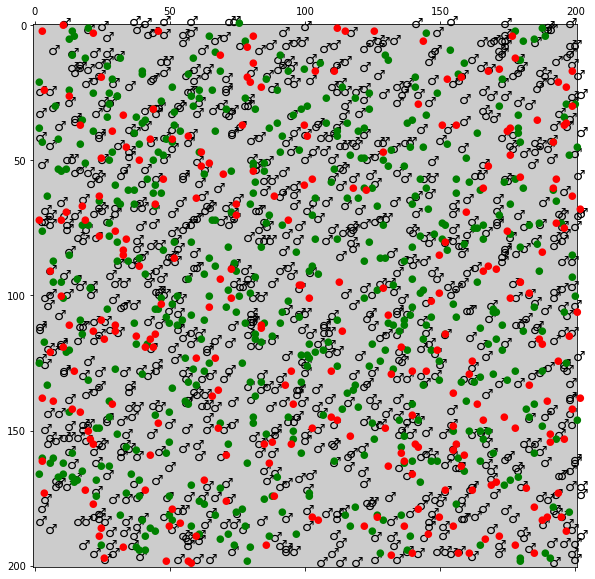

In [4]:
world.plot()

#### 1.2.2 Talent Distribution of All People

Talent of people is initialized from truncated normal distribution $\mathcal{N}(0.6, 0.1)$ (max = 1.0, min = 0.0).

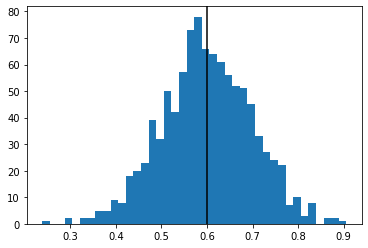

In [234]:
talents = [person.talent for person in world.people]
plt.hist(talents, bins=40)
plt.axvline(x=0.60, color='k'); # mean talent = 0.60 (std = 0.10)

### 1.3 Run the Simulation Once

In [260]:
world = World(
    grid_length=201,
    n_people=1000,
    n_good_event=500,
    n_bad_event=250
)
world.simulate(n=4) # total number of event movings

#### Plot a Talent-Money Graph

From a "single" simulation, we can see that the most successful person is not necessarily the most talented one.

The talent of the most successful person = 0.5934
The talent of the least successful person = 0.6654


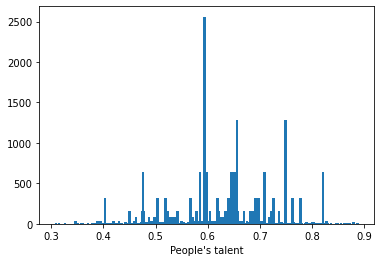

In [261]:
talents = np.array([person.talent for person in world.people])
moneys = np.array([person.money for person in world.people])

print(f"The talent of the most successful person = {talents[moneys.argmax()]:.4f}")
print(f"The talent of the least successful person = {talents[moneys.argmin()]:.4f}")
plt.bar(x=talents, height=moneys, width=0.005)
plt.xlabel("People's talent");

### 1.4 Run Simulations 1000 Times

In [216]:
from tqdm import tqdm

n_simulation = 1000
simulated_worlds = list()

for _ in tqdm(range(n_simulation)):
    world = World(
        grid_length=201,
        n_people=1000,
        n_good_event=500,
        n_bad_event=250
    )
    world.simulate(n=4) # total number of event movings
    simulated_worlds.append(world)

    del world

100%|██████████| 1000/1000 [01:57<00:00,  8.48it/s]


#### Examine 80-20 Rule
Indeed the top 20% people possess ~80% of total money.

Average proportion of money from the top 20% people: 83.38%


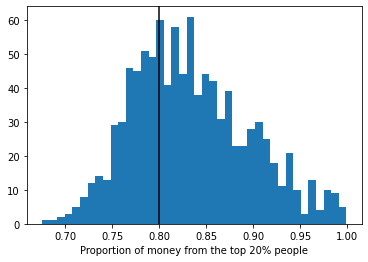

In [249]:
top_20_money_props = list()

for world in simulated_worlds:
    moneys = np.array([person.money for person in world.people])
    top_20_money_prop = moneys[moneys.argsort()[-int(0.20 * len(world.people)):]].sum() / moneys.sum()
    top_20_money_props.append(top_20_money_prop)

plt.hist(top_20_money_props, bins=40)
plt.axvline(x=0.80, color='k')
plt.xlabel("Proportion of money from the top 20% people")
print(f"Average proportion of money from the top 20% people: {np.array(top_20_money_props).mean() * 100:.2f}%")

#### Talent Distribution of The Most Successful People
The most successful people are indeed more talented on average. However, there are also a substantial proportion of less talented people (i.e., worse than the average of 0.60) who become the most successful.

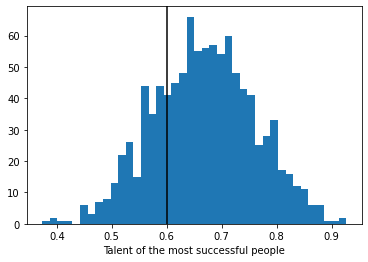

In [250]:
msuc_people_talents = list()

for world in simulated_worlds:
    moneys = np.array([person.money for person in world.people])
    msuc_person_id = moneys.argmax() # the person_id of the most successful person
    msuc_person_talent = world.people[msuc_person_id].talent
    msuc_people_talents.append(msuc_person_talent)

plt.hist(msuc_people_talents, bins=40)
plt.axvline(x=0.60, color='k')
plt.xlabel("Talent of the most successful people");